# Comparing with Michele, plus differences

## Setup

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.cosmology import FlatLambdaCDM

In [3]:
%cd ../

/Users/af/Work/Cosmo/codes/Xi0Stat


In [4]:
from Xi0Stat.globals import * 
from Xi0Stat.GW import get_all_events
from Xi0Stat.GLADE import GLADE
from Xi0Stat.GWENS import GWENS
from Xi0Stat.SYNTH import SYNTH
from Xi0Stat.completeness import *
from Xi0Stat.galCat import GalCompleted
from Xi0Stat.GWgal import GWgal
from Xi0Stat.betaHom import BetaHom

In [5]:
%load_ext autoreload
%autoreload 2

## Set global prior range! 
reload GW events after change! 
reset GWgal object after change to either GWs or gal! 

In [6]:
lims = PriorLimits() 
lims.Xi0min=1
lims.Xi0max=1
lims.H0min=40
lims.H0max=140

In [7]:

O2 = get_all_events(lims, loc='data/GW/O2/', verbose=True, level=0.96, subset=True, subset_names=['GW170608','GW150914', 'GW170814', 'GW151226'])


--- GW events:
['GW151226', 'GW170608', 'GW170814', 'GW150914']
Reading skymaps....


/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Event name: GW151226 



/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Event name: GW170608 

Event name: GW170814 

Event name: GW150914 



## Completeness

In [8]:
from Xi0Stat.completeness import LoadCompleteness

compl = SkipCompleteness()

goal = get_SchNorm(phistar=phiBstar07, Lstar=LBstar07, alpha=alphaB07, Lcut=0.6)
#goal = 0.1

compl = MaskCompleteness(comovingDensityGoal=goal, nMasks=5, zRes=40)

#compl = LoadCompleteness(fname='Michele_B.txt', interpolateOmega=False)


#compl = SuperpixelCompleteness(comovingDensityGoal=goal, angularRes=4, interpolateOmega=False, zRes=40)

## GLADE

In [9]:
# uncomment to compute posteriors and save. then put file into GLADE folder, comment, and proceed. 
#skipcompl = SkipCompleteness()
#glade = GLADE('GLADE', skipcompl, useDirac=False, computePosterior=False, verbose=True, colnames_final = ['theta','phi','z','z_err', 'z_lower', 'z_lowerbound', 'z_upper', 'z_upperbound', 'w', 'K', 'B_Abs'])
# glade.data.to_csv('posteriorglade.csv', index=False)  

## ---------------------------------------------------------- ##

#glade = GLADE('GLADE', compl, useDirac=False, finalData='posteriorglade.csv', verbose=True)
band = 'B'
Lcut = 0.6
glade = GLADE('GLADE', compl, useDirac=False, finalData='posteriorglade.csv', verbose=True, band=band, Lcut=Lcut)


Directly loading final data posteriorglade.csv
Computing total luminosity in B band...
Applying cut in luminosity in B-band. Selecting galaxies with B_Lum>0.6 x L_* = 1.47
Kept 1148638 points or 42% of total
Using B_Lum for weighting
Keeping only columns: ['theta', 'phi', 'z', 'z_err', 'z_lower', 'z_lowerbound', 'z_upper', 'z_upperbound', 'w']
Done.
Computing completeness
Making masks...
Preparing further... 
Computing in parallel... 
Final computations for completeness...
Done.


## Computing posterior

In [20]:
%%time
gals = GalCompleted(completionType='add')
gals.add_cat(glade)

myGWgal = GWgal(gals, O2)

# Compute likelihood for H0 on a grid
H0grid = np.linspace(lims.H0min, lims.H0max, 50)
#H0grid = np.linspace(70, 70, 1)
#Xi0grid = np.linspace(0.3,10,60)
Xi0grid = np.linspace(1,1,1)

#If false, use diracs
myGWgal._galRedshiftErrors = False

# 400 gives reasonable but noisy results. Will need >> 10k for production 
myGWgal.nHomSamples = 3999


liks = myGWgal.get_lik(H0s=H0grid, Xi0s=Xi0grid, n=nGlob)



Restricting area of the catalogue to 26536 pixels with nside=256
39495 galaxies kept
Setting z range of the catalogue between 0.00882875222920615, 0.26320284581075676
37216 galaxies kept
Restricting area of the catalogue to 41312 pixels with nside=512
18817 galaxies kept
Setting z range of the catalogue between 0.016834570654748134, 0.1920996209746734
15295 galaxies kept
Restricting area of the catalogue to 50288 pixels with nside=1024
5162 galaxies kept
Setting z range of the catalogue between 0.028013255155046803, 0.32518659391465554
5111 galaxies kept
Restricting area of the catalogue to 21440 pixels with nside=512
6309 galaxies kept
Setting z range of the catalogue between 0.022218707131412677, 0.24441429931070044
6191 galaxies kept
CPU times: user 1min 47s, sys: 33 s, total: 2min 20s
Wall time: 2min 27s


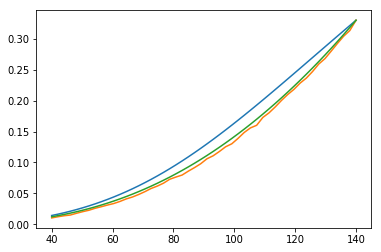

In [42]:
from Xi0Stat.betaFit import BetaFit
from Xi0Stat.betaMC import BetaMC

bfit = BetaFit()
bmc = BetaMC(lims)


bfitres = bfit.get_beta(H0grid, Xi0grid)
bmcres = bmc.get_beta(H0grid, Xi0grid)

plt.plot(H0grid, bfitres)
plt.plot(H0grid, bmcres*bfitres[-1]/bmcres[-1])


r = 440 
bhomres = H0grid**3 / (1+np.array([z_from_dLGW(r*1.5, Xi0=1, n=nGlob, H0 = h) for h in H0grid]))**3

plt.plot(H0grid, bhomres*bfitres[-1]/bhomres[-1])


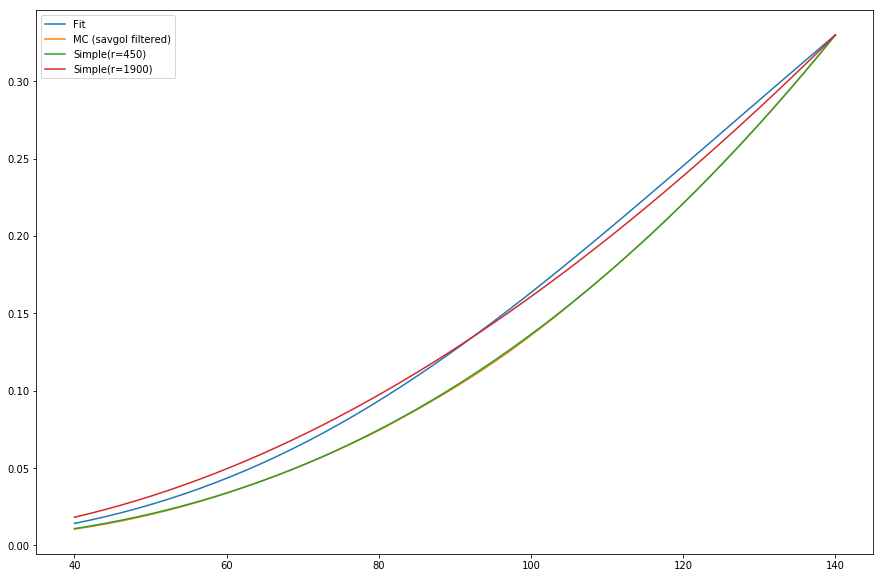

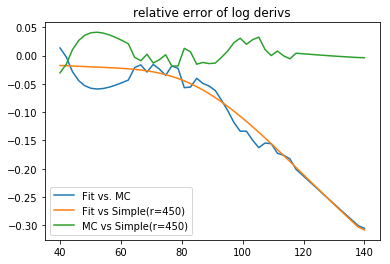

In [52]:
plt.figure(figsize=(15,10))
plt.plot(H0grid, bfitres)

from scipy.signal import savgol_filter
bmcresfilterd = savgol_filter(bmcres, 25, 3, deriv=0)
plt.plot(H0grid, bmcresfilterd*bfitres[-1]/bmcresfilterd[-1])


r = 300 
bhomres = H0grid**3 / (1+np.array([z_from_dLGW(r*1.5, Xi0=1, n=nGlob, H0 = h) for h in H0grid]))**3
r = 1200 
bhomres2 = H0grid**3 / (1+np.array([z_from_dLGW(r*1.5, Xi0=1, n=nGlob, H0 = h) for h in H0grid]))**3


plt.plot(H0grid, bhomres*bfitres[-1]/bhomres[-1])
plt.plot(H0grid, bhomres2*bfitres[-1]/bhomres2[-1])
plt.legend(['Fit', 'MC (savgol filtered)','Simple(r=450)', 'Simple(r=1900)'])


plt.show()
plt.title('relative error of log derivs')
plt.plot(H0grid, (np.gradient(np.log(bfitres), H0grid)-np.gradient(np.log(bmcresfilterd), H0grid))/np.gradient(np.log(bmcresfilterd), H0grid))
plt.plot(H0grid, (np.gradient(np.log(bfitres), H0grid)-np.gradient(np.log(bhomres), H0grid))/np.gradient(np.log(bhomres), H0grid))
plt.plot(H0grid, (np.gradient(np.log(bmcresfilterd), H0grid)-np.gradient(np.log(bhomres), H0grid))/np.gradient(np.log(bhomres), H0grid))

plt.legend(['Fit vs. MC', 'Fit vs Simple(r=450)', 'MC vs Simple(r=450)'])

## Plot H0 results 

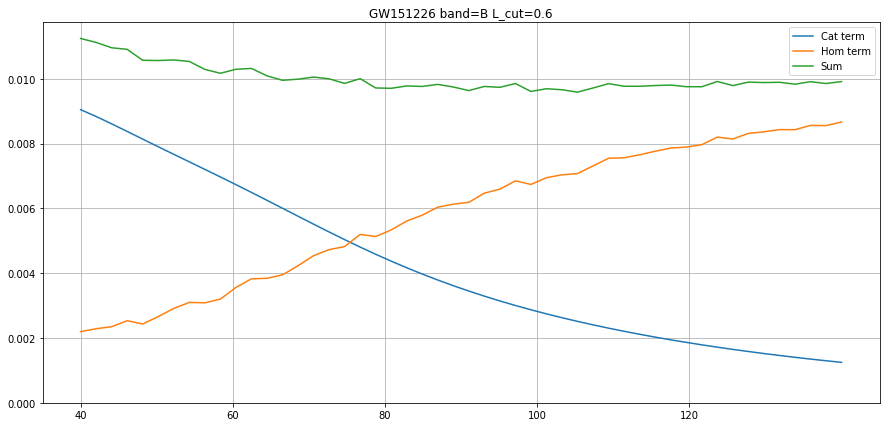

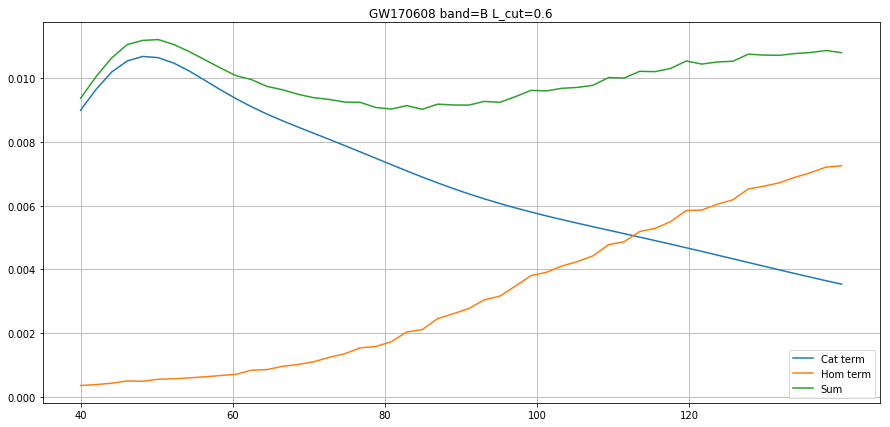

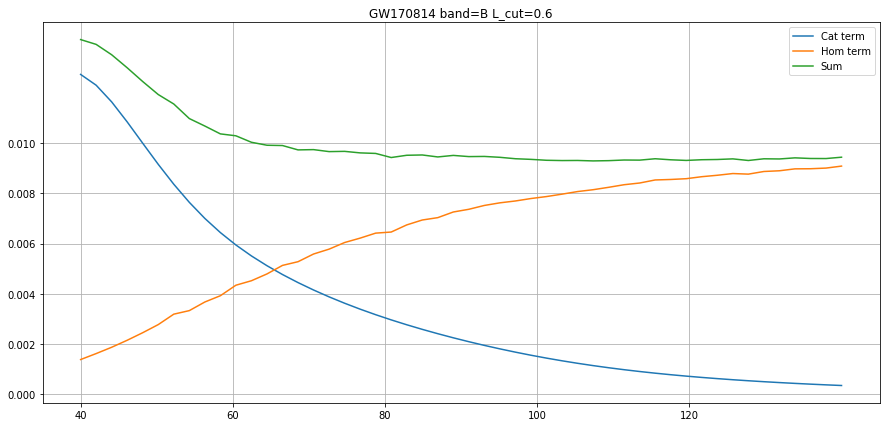

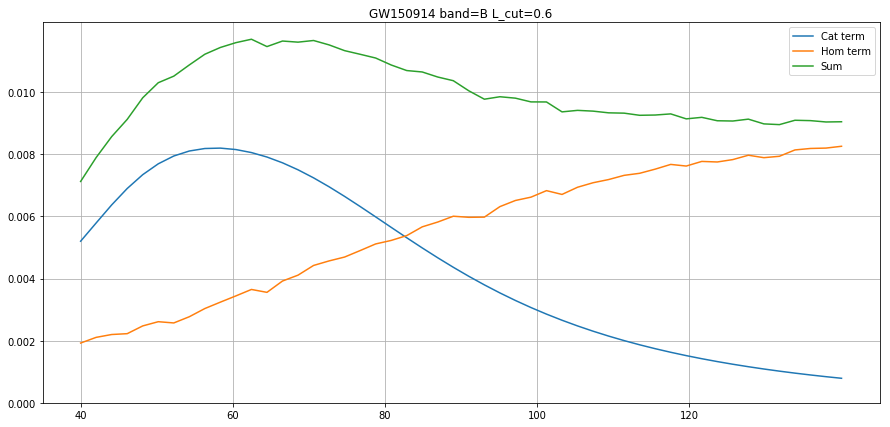

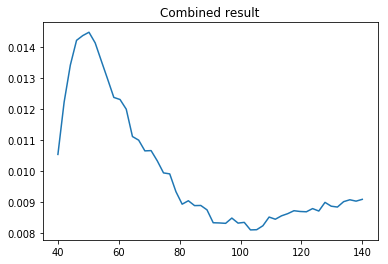

In [21]:


lik = np.squeeze(np.ones((H0grid.size, Xi0grid.size)))
bet = np.squeeze(np.ones((H0grid.size, Xi0grid.size)))

for key, val in liks.items():
    
    r, _, _, _ = O2[key].find_r_loc()

    beta = H0grid**3 / (1+np.array([z_from_dLGW(r*1.5, Xi0=1, n=nGlob, H0 = h) for h in H0grid]))**3
    
    fig = plt.figure(figsize=(15,7))
    norm = 1/np.trapz((val[0]+1*val[1])/beta, H0grid)
    plt.plot(H0grid, norm*val[0]/beta)
    plt.plot(H0grid, norm*val[1]/beta)
    plt.plot(H0grid, norm*(val[0]+1*val[1])/beta)
    plt.legend(["Cat term", "Hom term", "Sum"])
    plt.title( key + " band=" + band + " L_cut=" + str(Lcut) )
    ax = fig.gca()
    ax.set_xticks(np.arange(H0grid[0], H0grid[-1], 20))
    ax.set_yticks(np.arange(0.000, 0.012, 0.002))

    plt.grid()
    plt.show()
    
    
    lik *= (val[0] + val[1] )
    bet *= beta

    
# # Plot the posterior with beta=H0^3
# plt.imshow(lik, extent=[Xi0grid[0],Xi0grid[-1],H0grid[0],H0grid[-1]])
# plt.colorbar()


# plt.show()




norm=np.trapz(lik/bet, H0grid)
plt.plot(H0grid, lik/bet/norm)
plt.title('Combined result')
plt.show()  

## Plot Xi0 results

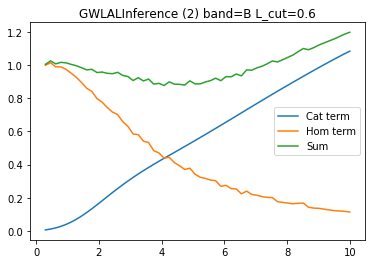

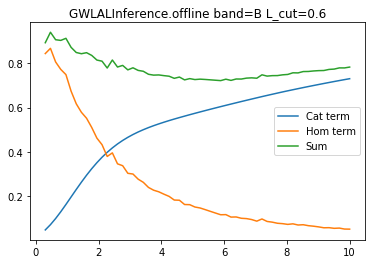

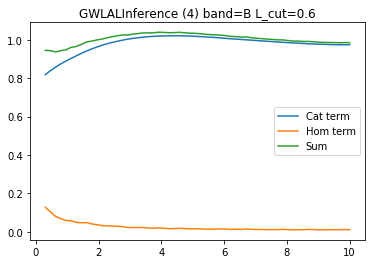

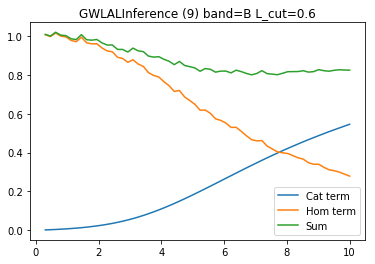

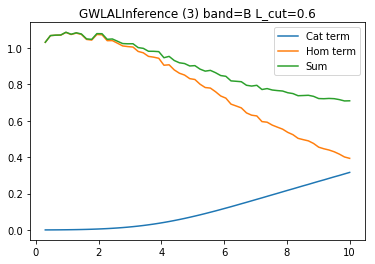

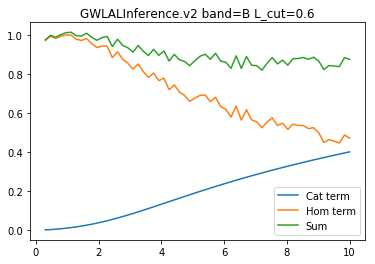

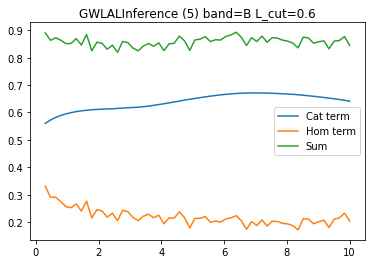

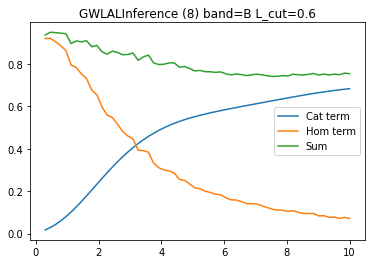

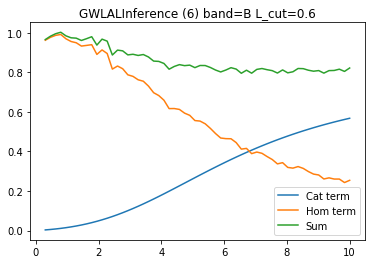

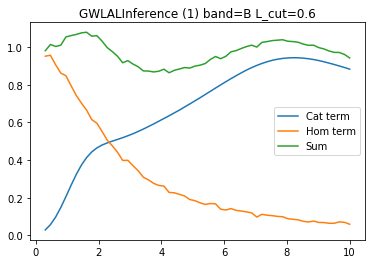

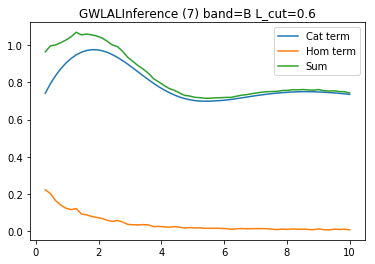

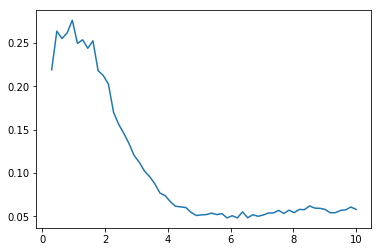

In [129]:


lik = np.squeeze(np.ones((H0grid.size, Xi0grid.size)))
bet = np.squeeze(np.ones((H0grid.size, Xi0grid.size)))

for key, val in liks.items():

    r, _, _, _ = O2[key].find_r_loc()
    #d = O2[key].d_max()
    d = r*1.5
    beta = 1 / np.array([Xi(z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70), Xi0, n=nGlob)*(1+z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70)) for Xi0 in Xi0grid])**3
    #beta = 1 / (1+np.array([z_from_dLGW(r*1.5, Xi0=Xi0, n=nGlob, H0 = 70) for Xi0 in Xi0grid]))**3
    #plt.figure(figsize=(20,10))
    plt.plot(Xi0grid, val[0]/beta)
    plt.plot(Xi0grid, 1*val[1]/beta)
    plt.plot(Xi0grid, (val[0]+1*val[1])/beta)

    plt.legend(["Cat term", "Hom term", "Sum"])
    plt.title( key + " band=" + band + " L_cut=" + str(Lcut) )
    plt.show()
    
    
    lik *= (val[0] + val[1] )
    bet *= beta

    
norm=np.trapz(lik/bet, Xi0grid)
plt.plot(Xi0grid, lik/bet/norm)
plt.show()

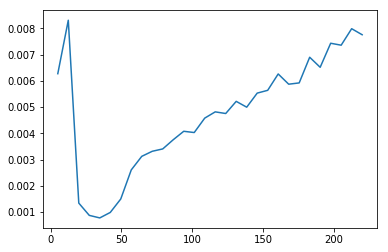

In [133]:
# # Plot the posterior with beta=H0^3
# plt.imshow(lik, extent=[Xi0grid[0],Xi0grid[-1],H0grid[0],H0grid[-1]])
# plt.colorbar()


# plt.show()


# norm=np.trapz(lik[:,0]/H0grid**3, H0grid)
# plt.plot(H0grid, lik[:,0]/H0grid**3/norm)
# plt.show()

norm=np.trapz(lik/bet, H0grid)
plt.plot(H0grid, lik/bet/norm)
plt.show()

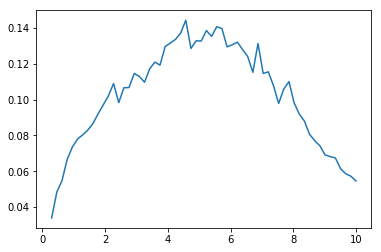

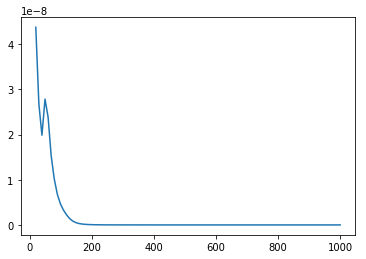

In [170]:
plt.plot(H0grid[:], lik_inhom[:]/H0grid[:]**6)

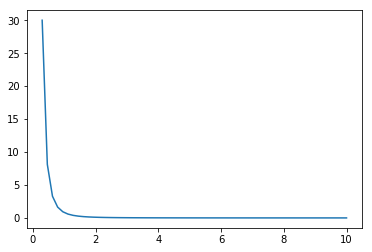

In [97]:
beta = 1 / np.array([Xi0*(1+z_from_dLGW(300, Xi0=Xi0, n=nGlob, H0 = 70)) for Xi0 in Xi0grid])**3
plt.plot(Xi0grid, beta)

In [253]:
gals.eval_hom(theta = np.array([0, 0, 1,1]), phi = np.array([0,1, 0, 1]), z=np.array(4*[0.1]))

array([0.99284882, 0.99284882, 0.97867915, 0.98610612])

In [263]:
dVdcom_dVdLGW(0.1, H0=70, Xi0=1, n=nGlob)

0.687305805934098

(100, 200)


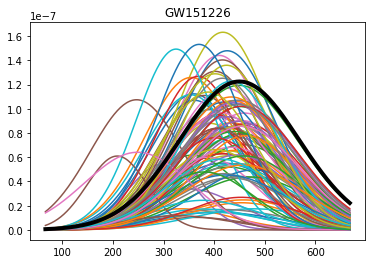

(100, 200)


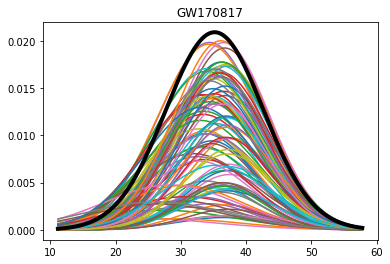

(100, 200)


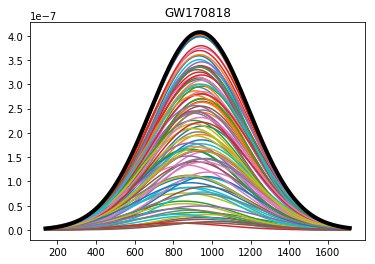

(100, 200)


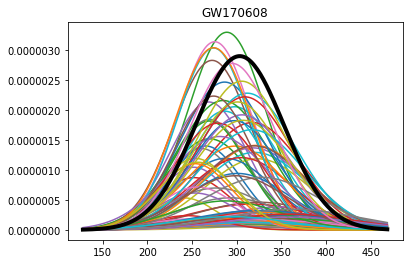

(100, 200)


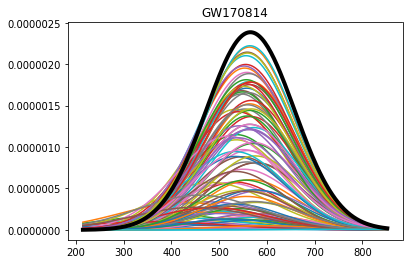

(100, 200)


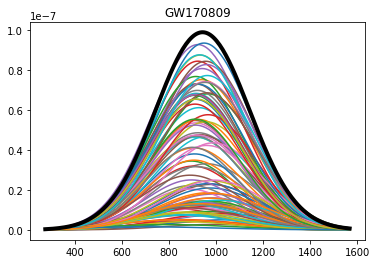

(100, 200)


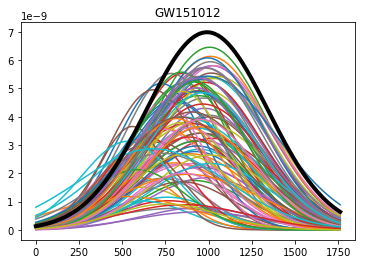

(100, 200)


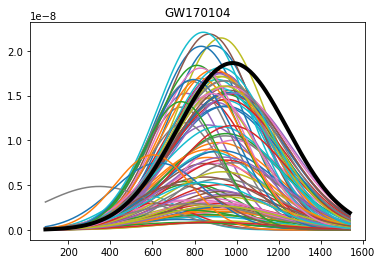

(100, 200)


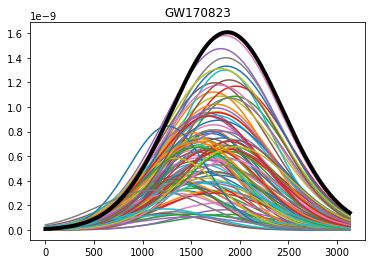

(100, 200)


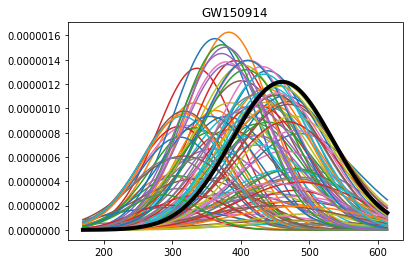

In [204]:
for key, ev in O2.items():
    mu, l, u, sig = ev.find_r_loc(std_number=3)
    r = np.linspace(l, u, 200)
    theta, phi, _ = ev.sample_posterior(nSamples=100)
    
    theta = theta[:, None]
    phi = phi[:, None]
    resMax = ev.likelihood(r, *ev.find_event_coords(polarCoords=True))
    r = r[None, :]
    res = ev.likelihood(r, theta, phi)
    print(res.shape)
    plt.plot(np.squeeze(r), res.T)
    plt.plot(np.squeeze(r), resMax, c='k', linewidth=4)
    plt.title(key)
    plt.show()
    


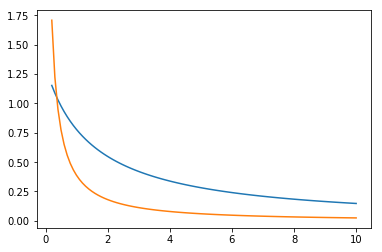

In [285]:
Xi0grid = np.linspace(0.2,10,100)
d = 400
beta1 = 1 / np.array([Xi(z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70), Xi0, n=nGlob)*(1+z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70)) for Xi0 in Xi0grid])**3
d = 2000
beta2 = 1 / np.array([Xi(z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70), Xi0, n=nGlob)*(1+z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70)) for Xi0 in Xi0grid])**3

plt.plot(Xi0grid, beta1, Xi0grid, beta2)

In [334]:
from Xi0Stat.betaMC import BetaMC
lims = PriorLimits()
lims.Xi0Min=0.01
lims.Xi0Max=100
lims.H0Min=70
lims.H0Max=70
Xi0grid = np.linspace(0.1,10,50)
b = BetaMC(priorlimits=lims, verbose=True,nSamples=1000000)
#betaH0 = np.array([b.compute_at(H0=H0, Xi0=1) for H0 in H0grid])
betaXi03 = np.array([b.compute_at(H0=70, Xi0=Xi0, gamma=0.5) for Xi0 in Xi0grid])
 
#beta2 = 1 / np.array([Xi(z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70), Xi0, n=nGlob)*(1+z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70)) for Xi0 in Xi0grid])**3
 

Loading strain sensitivity from /Users/af/Work/Cosmo/codes/Xi0Stat/Xi0Stat/../data/GW/detectors/2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt...
Largest distance detected in sample is 1978.0257460056175
Largest distance detected in sample is 2001.3244841615322
Largest distance detected in sample is 2022.8426739199106
Largest distance detected in sample is 1655.31074828152
Largest distance detected in sample is 1840.70481348352
Largest distance detected in sample is 1648.1747230219964
Largest distance detected in sample is 1625.120902122176
Largest distance detected in sample is 1641.1918650168425
Largest distance detected in sample is 1352.6207207212342
Largest distance detected in sample is 1558.9384746138078
Largest distance detected in sample is 1378.5532007238915
Largest distance detected in sample is 1869.8209293574548
Largest distance detected in sample is 1512.4830728140573
Largest distance detected in sample is 1835.5709369049557
Largest distance detected in sample is 158

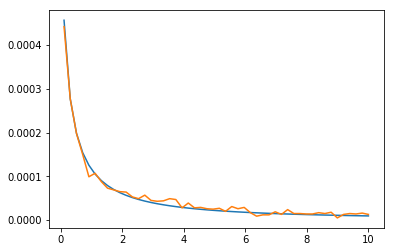

In [343]:
d=1300
betaXi02 = 1 / np.array([Xi(z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70), Xi0, n=nGlob)*(1+z_from_dLGW(d, Xi0=Xi0, n=nGlob, H0 = 70)) for Xi0 in Xi0grid])**3
 

#plt.plot(Xi0grid, betaXi0)
plt.plot(Xi0grid, betaXi02*betaXi03[1]/betaXi02[1])
plt.plot(Xi0grid, np.array(betaXi03))#*betaXi0[1]/betaXi03[1])

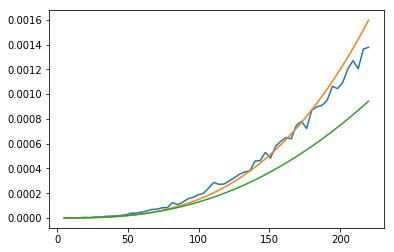

In [323]:
d = 500
beta2 = H0grid**3 / (1+np.array([z_from_dLGW(d, Xi0=1, n=nGlob, H0 = h) for h in H0grid]))**3
 

plt.plot(H0grid, beta)
plt.plot(H0grid, 0.00000000015*H0grid**3)
plt.plot(H0grid, 0.7*0.00000000028*beta2)

In [197]:
gals.get_inhom_contained(np.linspace(0.005,1,6), 16)

(array([2906, 2867, 2906, ..., 2767, 2767, 2897]),
 array([[3.43936370e+02, 1.92689799e+02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.55023702e+02, 8.68517802e+01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [3.01465837e+02, 1.68895751e+02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 4.20968883e+02, 2.24524355e-11, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [2.03314061e+01, 4.36767178e+02, 1.89612008e-11, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.42869237e+02, 5.43579984e-11, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00]]))

In [268]:
from Xi0Stat.globals import *
h7 = 220/70 
print(Xi(z=2.358473740319262, Xi0=1,n=nGlob)*dL70fast(2.358473740319262
)/h7)

6046.247806837064


In [267]:
Xi(z=2.358473740319262, Xi0=1,n=nGlob)

1.0

In [288]:
z_from_dLGW(1000, H0=220, Xi0=0.01, n=nGlob)

2.358473740319262

In [266]:
Xi0minGlob

1

In [287]:
b.zmax

2.358473740319262